# Wine Case Analysis: *Wine Spectator*'s Top 100 Wines, 1988-2020
List available online on *Wine Spectator*'s [Top 100 Lists web site](https://top100.winespectator.com/lists/).

## File Setup

In [560]:
# import and initialize main python libraries
import numpy as np
import pandas as pd
import shapefile as shp
import matplotlib.pyplot as plt
import bar_chart_race as bcr
import seaborn as sns

# import libraries for file navigation
import os
import shutil
import glob
from pandas_ods_reader import read_ods

# import other packages
from scipy import stats
from sklearn import linear_model

# import geo packages
import geopandas as gpd
import descartes
from shapely.geometry import Point, Polygon

# import Geopy packages
import geopy
from geopy.geocoders import Nominatim

In [561]:
# initialize vizualization set
sns.set(style="whitegrid", palette="colorblind", color_codes=True)
sns.mpl.rc("figure", figsize=(10, 6))

# Jupyter Notebook
%matplotlib inline

## Dataframe Exploration

In [562]:
# Note: save CSV files in UTF-8 format to preserve special characters.
df_Wine = pd.read_csv('./Wine_Hier00.csv')
df_GeoCache = pd.read_csv('./GeoCache.csv')
df_Flag = pd.read_csv('./emoji_list.csv')

In [563]:
df_Wine.shape

(3301, 25)

In [564]:
df_Wine.dtypes

Review_Year           float64
Rank                   object
Vintage                object
Score                 float64
Price                  object
Winemaker              object
Wine                   object
Wine_Style             object
Grape_Blend            object
Blend_List             object
Geography              object
Cases_Made            float64
Cases_Imported        float64
Reviewer               object
Drink_now             float64
Best_Drink_from       float64
Best_Drink_Through    float64
Review                 object
Hierarchy              object
Address                object
loc                    object
point                  object
lat                   float64
long                  float64
altitude              float64
dtype: object

In [565]:
# CSV of wines is retaining a blank row at the end of the dataset. Remove the last row to prevent data type errors.

# number of rows to drop
n = 1

df_Wine.drop(df_Wine.tail(n).index, inplace = True)

In [566]:
# Review_Year
# Convert Review_Year from float to int
df_Wine['Review_Year'] = df_Wine['Review_Year'].astype(int)

In [567]:
df_GeoCache.shape

(1224, 8)

In [568]:
df_Flag.shape

(19, 3)

In [569]:
df_Wine.sample(10)

,Review_Year,Rank,Vintage,Score,Price,Winemaker,Wine,Wine_Style,Grape_Blend,Blend_List,...,Best_Drink_from,Best_Drink_Through,Review,Hierarchy,Address,loc,point,lat,long,altitude
691,2014,92,2010,90.0,15,Vecchia Cantina di Montepulciano,Vino Nobile di Montepulciano Incanto,Red,Sangiovese,NaN,...,2016.0,2027.0,"Rich and rangy, this black cherry, plum-, tar...",Hierarchy_00,Italy,Italia,"(42.6384261, 12.674297, 0.0)",42.638426,12.674297,0.0
2482,1996,83,1994,90.0,15,Bernardus,Chardonnay Monterey County,White,Chardonnay,NaN,...,NaN,NaN,"A bold, ripe and full-bodied white from Califo...",Hierarchy_00,USA,United States,"(39.7837304, -100.4458825, 0.0)",39.783730,-100.445882,0.0
3281,1988,82,1985,91.0,10,Preston,Syrah-Sirah Dry Creek Valley,Red,Shiraz | Syrah,NaN,...,NaN,NaN,"Bursting with fresh, lively fruit. Lots of bla...",Hierarchy_00,USA,United States,"(39.7837304, -100.4458825, 0.0)",39.783730,-100.445882,0.0
2854,1992,55,1990,92.0,24,Flora Springs,Chardonnay Napa Valley Barrel Fermented,White,Chardonnay,NaN,...,1992.0,NaN,"Smooth, ripe and generous, with rich, complex,...",Hierarchy_00,USA,United States,"(39.7837304, -100.4458825, 0.0)",39.783730,-100.445882,0.0
1257,2008,58,2005,90.0,20,Louis Latour,Marsannay,Red,Pinot Noir,NaN,...,2010.0,2020.0,"Lean and solidly built, despite its ripe cherr...",Hierarchy_00,France,France,"(46.603354, 1.8883335, 0.0)",46.603354,1.888333,0.0
287,2018,88,2014,93.0,49,Paolo Scavino,Barolo,Red,Blend,Nebbiolo,...,2023.0,2040.0,"This starts out with plenty of cherry, plum an...",Hierarchy_00,Italy,Italia,"(42.6384261, 12.674297, 0.0)",42.638426,12.674297,0.0
801,2012,2,2010,95.0,41,Château de St.-Cosme,Gigondas,Red,Blend,Southern Rhone Red Blend,...,2015.0,2030.0,"This is jam-packed with dark blackberry, curra...",Hierarchy_00,France,France,"(46.603354, 1.8883335, 0.0)",46.603354,1.888333,0.0
693,2014,94,2011,90.0,19,Château Lamartine,Cahors,Red,Blend,Malbec and Merlot,...,2014.0,2019.0,There's a ripe plushness to the dried blackber...,Hierarchy_00,France,France,"(46.603354, 1.8883335, 0.0)",46.603354,1.888333,0.0
2244,1998,18,1996,92.0,21,Landmark,Chardonnay Sonoma County Overlook,White,Chardonnay,NaN,...,NaN,NaN,"A very spicy, rich, flavorful and complex Char...",Hierarchy_00,USA,United States,"(39.7837304, -100.4458825, 0.0)",39.783730,-100.445882,0.0
1657,2004,58,2001,92.0,30,Château Giscours,Margaux,Red,Blend,Bordeaux Blend Red,...,2009.0,NaN,"Incredible aromas of flowers, currants, blackb...",Hierarchy_00,France,France,"(46.603354, 1.8883335, 0.0)",46.603354,1.888333,0.0


## Clean up data types

In [570]:
# replace 'NaN' results in chart with 0 to facilitate analysis
df_Wine.fillna(value = 0, inplace = True)

In [571]:
# drop the non-numeric price row from the dataset
df_Wine = df_Wine[df_Wine.Price != '$49 / 500ml']

In [572]:
# Convert data type of price to numeric
df_Wine['Price'] = pd.to_numeric(df_Wine.Price, downcast = 'float')

In [573]:
df_Wine.dtypes

Review_Year             int64
Rank                   object
Vintage                object
Score                 float64
Price                 float32
Winemaker              object
Wine                   object
Wine_Style             object
Grape_Blend            object
Blend_List             object
Geography              object
Cases_Made            float64
Cases_Imported        float64
Reviewer               object
Drink_now             float64
Best_Drink_from       float64
Best_Drink_Through    float64
Review                 object
Hierarchy              object
Address                object
loc                    object
point                  object
lat                   float64
long                  float64
altitude              float64
dtype: object

In [574]:
# Remove Non-Vintage (NV) wines from df_Wine
# Include only wines with a Cases_Made value

#df_Wine_V = df_Wine[
#    (df_Wine.Vintage != 'NV')
#]

#df_Wine_V.shape

In [575]:
# Average Score by Wine Style - All Years
df_SWS_All = pd.DataFrame({'Avg_Score' : df_Wine.groupby(['Wine_Style'])['Score'].mean()}).reset_index()
df_SWS_All

,Wine_Style,Avg_Score
0,Dessert & Fortified,94.910256
1,Red,93.127455
2,Rosé | Rosado,90.444444
3,Sparkling,92.528090
4,White,91.987981


In [576]:
# Average Score by Wine Style - By Review Year
df_SWS_ByYear = pd.DataFrame({'Avg_Score' : df_Wine.groupby(['Review_Year', 'Wine_Style'])['Score'].mean()}).reset_index()
df_SWS_ByYear.sample(10)

,Review_Year,Wine_Style,Avg_Score
39,1998,Red,93.700000
46,2000,Red,93.883117
87,2010,White,92.454545
14,1991,Sparkling,90.500000
94,2012,Sparkling,94.000000
66,2005,Sparkling,93.000000
99,2013,Sparkling,93.000000
11,1990,White,92.580645
63,2004,White,91.826087
1,1988,Red,93.802632


In [577]:
# Average Score by Wine Style - All Years
df_PWS_All = pd.DataFrame({'Avg_Price' : df_Wine.groupby(['Wine_Style'])['Price'].mean()}).reset_index()
df_PWS_All

,Wine_Style,Avg_Price
0,Dessert & Fortified,60.641026
1,Red,46.101704
2,Rosé | Rosado,24.777779
3,Sparkling,52.640450
4,White,29.033653


In [578]:
# Average Score by Wine Style - By Vintage Year
df_PWS_ByYear = pd.DataFrame({'Avg_Price' : df_Wine.groupby(['Review_Year', 'Wine_Style'])['Price'].mean()}).reset_index()
df_PWS_ByYear.sample(10)

,Review_Year,Wine_Style,Avg_Price
1,1988,Red,42.697369
110,2016,Dessert & Fortified,39.500000
27,1995,Red,42.545456
65,2005,Red,41.950001
70,2006,Sparkling,129.500000
2,1988,Sparkling,68.000000
0,1988,Dessert & Fortified,74.000000
66,2005,Sparkling,47.500000
56,2003,Dessert & Fortified,66.000000
52,2001,White,25.653847


In [579]:
# Average Score by Address - All Years
df_SA_All = pd.DataFrame({'Avg_Score' : df_Wine.groupby(['Address'])['Score'].mean()}).reset_index()
df_SA_All

,Address,Avg_Score
0,Argentina,91.982456
1,Australia,92.438776
2,Austria,91.571429
3,Canada,94.000000
4,Chile,92.122807
5,France,93.554020
6,Germany,92.213115
7,Greece,90.272727
8,Hungary,94.250000
9,Israel,91.000000


In [580]:
# Average Score by Address - By Review Year
df_SA_ByYear = pd.DataFrame({'Avg_Score' : df_Wine.groupby(['Review_Year', 'Address'])['Score'].mean()}).reset_index()
df_SA_ByYear.sample(10)

,Review_Year,Address,Avg_Score
127,2003,Austria,90.000000
218,2010,Germany,92.000000
281,2015,Australia,92.800000
210,2009,South Africa,93.000000
196,2008,Portugal,91.750000
240,2012,Australia,93.000000
128,2003,Chile,91.333333
70,1997,New Zealand,92.000000
16,1990,Italy,92.200000
342,2019,New Zealand,91.500000


In [581]:
# Average Score by Wine Style - All Years
df_PA_All = pd.DataFrame({'Avg_Price' : df_Wine.groupby(['Address'])['Price'].mean()}).reset_index()
df_PA_All

,Address,Avg_Price
0,Argentina,37.473682
1,Australia,34.739796
2,Austria,25.821428
3,Canada,55.000000
4,Chile,39.385963
5,France,56.013821
6,Germany,25.852459
7,Greece,18.090910
8,Hungary,80.625000
9,Israel,37.142857


In [582]:
# Average Score by Wine Style - By Review Year
df_PA_ByYear = pd.DataFrame({'Avg_Price' : df_Wine.groupby(['Review_Year', 'Address'])['Price'].mean()}).reset_index()
df_PA_ByYear.sample(10)

,Review_Year,Address,Avg_Price
256,2013,France,60.611111
51,1995,New Zealand,27.000000
83,1998,USA,36.750000
225,2010,Spain,20.888889
5,1988,Spain,39.666668
157,2005,South Africa,13.000000
22,1991,Italy,28.461538
133,2003,Portugal,57.333332
130,2003,Germany,23.799999
47,1995,Argentina,16.000000


### Visualization

In [583]:
# set palette and dimensions
palette = sns.color_palette('colorblind')

In [584]:
# define a function to graph summary data

def summary_barplot(price_or_score, style_or_address):
    
    if price_or_score == 'Price':
        if style_or_address == 'Wine_Style':
            df = df_PWS_All
        elif style_or_address == 'Address':
            df = df_PA_All
        else:
            print('select style or address')
    elif price_or_score == 'Score':
        if style_or_address == 'Wine_Style':
            df = df_SWS_All
        elif style_or_address == 'Address':
            df = df_SA_All
    else:
        print('price or score')
        
    g = sns.catplot(
        data = df,
        kind = 'bar',
        y = style_or_address,
        x = 'Avg_' + price_or_score
    )
    
    g.despine(left = True)
    g.set_axis_labels('Average ' + price_or_score, 'Wine Style')
    
    plt.suptitle('Average ' + price_or_score + ' by ' + style_or_address + ', 1988-2020', y = 1.1)
    plt.savefig('./images/catplot_avg_' + price_or_score + '_by_' + style_or_address + '.png')

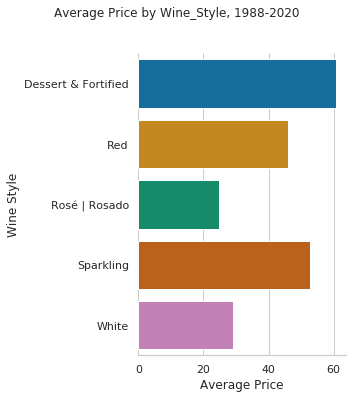

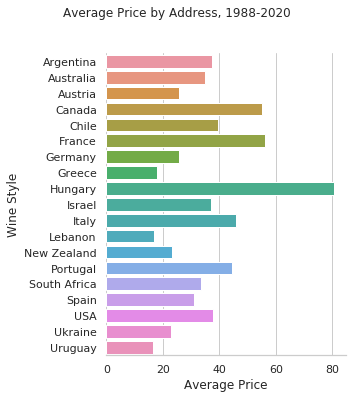

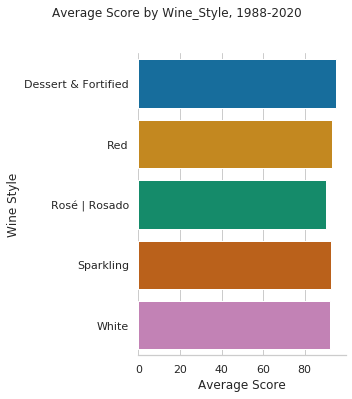

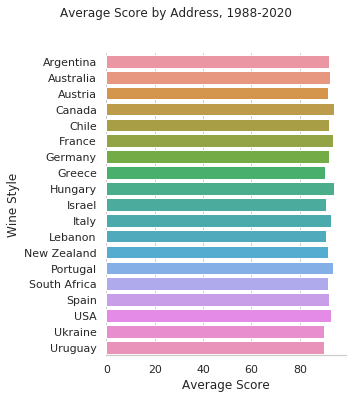

In [585]:
x_list = ['Price', 'Score']
y_list = ['Wine_Style', 'Address']

for x in x_list:
    for y in y_list:
        summary_barplot(x, y)

In [596]:
# define a function to graph summary data

def summary_boxplot(price_or_score, style_or_address):
    
    df = df_Wine_V
    
    sns.mpl.rc("figure", figsize=(15, 10))
    
    g = sns.boxplot(
        data = df,
        y = style_or_address,
        x = price_or_score,
        showmeans = True
    )
    
    plt.suptitle(price_or_score + ' by ' + style_or_address + '/nReview Years 1988-2020')
    plt.savefig('./images/boxplot_' + price_or_score + '_by_' + style_or_address + '.png')

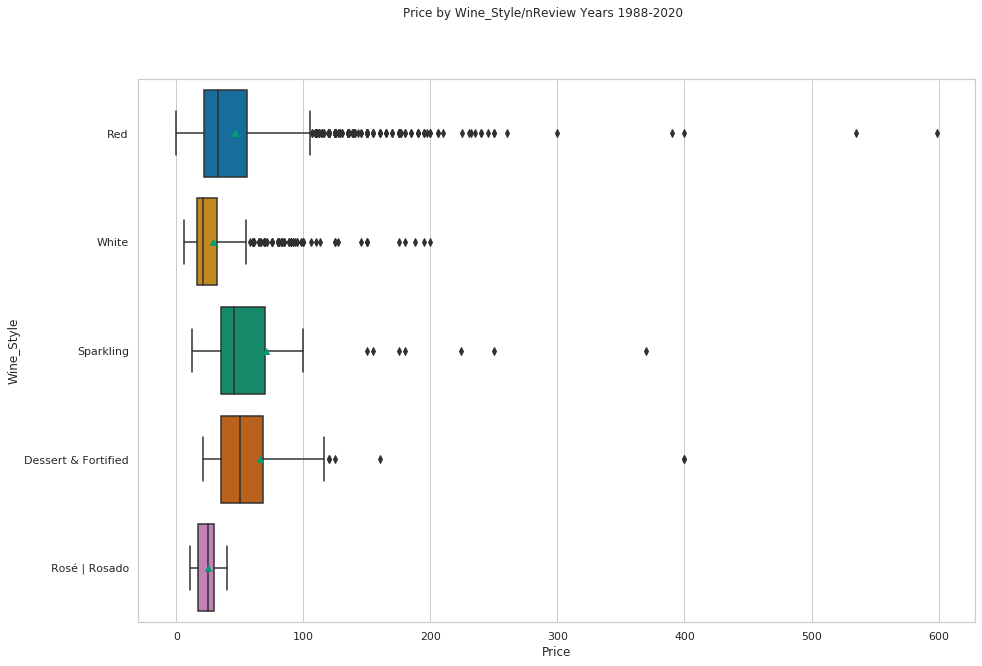

In [597]:
summary_boxplot('Price', 'Wine_Style')

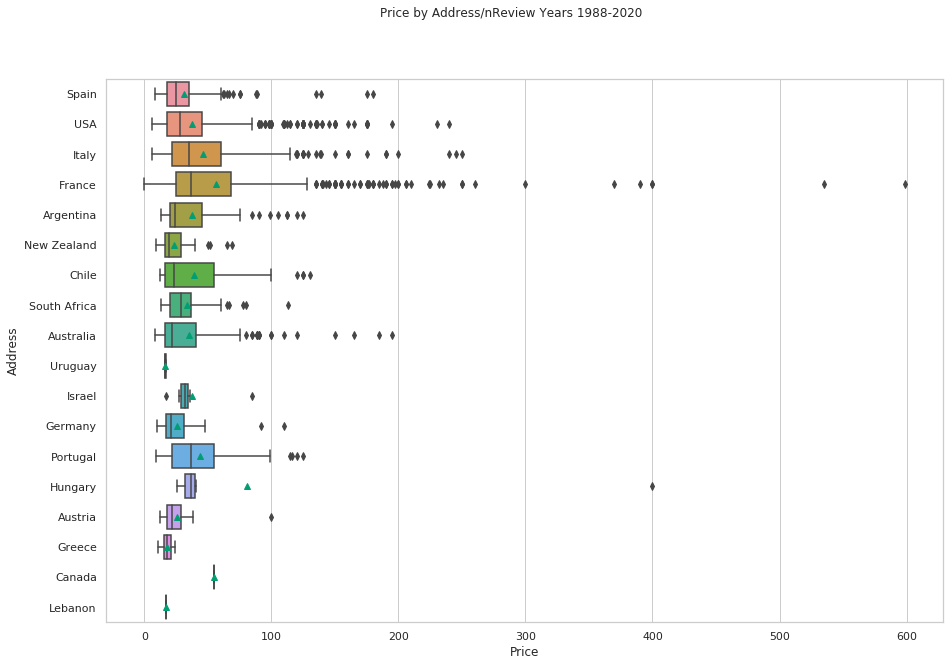

In [598]:
summary_boxplot('Price', 'Address')

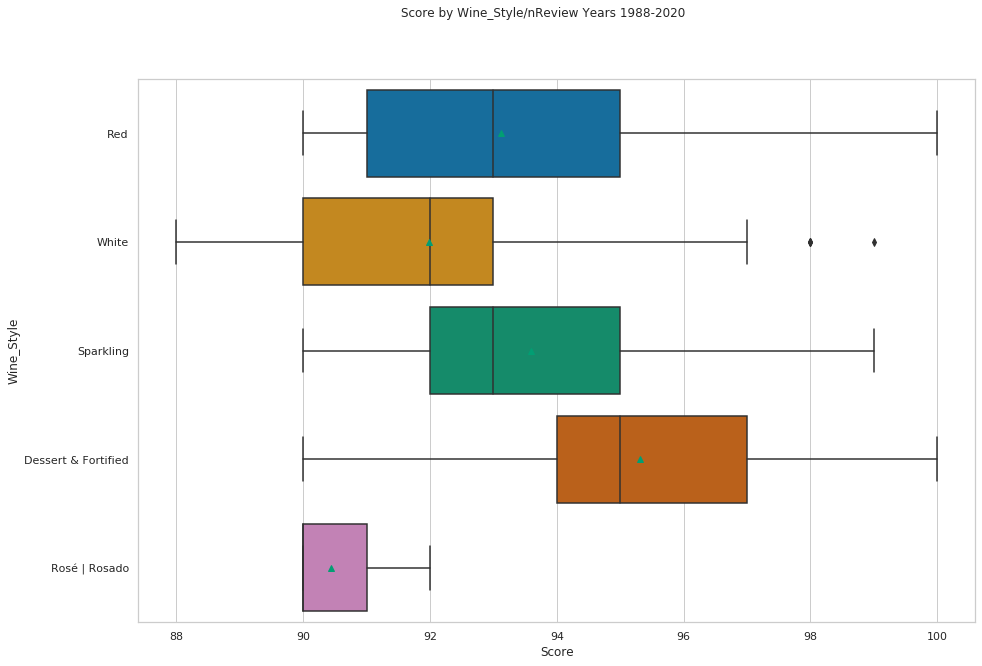

In [599]:
summary_boxplot('Score', 'Wine_Style')

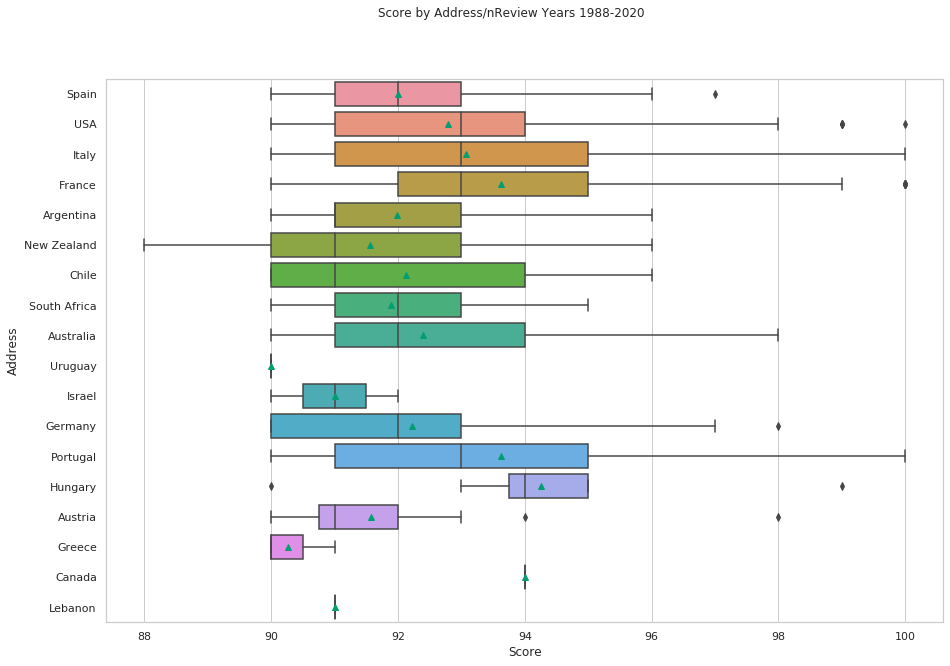

In [600]:
summary_boxplot('Score', 'Address')

In [591]:
# define a function to graph summary data by Review Year

def summary_by_year_lineplot(price_or_score, style_or_address):
    if price_or_score == 'Price':
        if style_or_address == 'Wine_Style':
            df = df_PWS_ByYear
        elif style_or_address == 'Address':
            df = df_PA_ByYear
        else:
            print('select style or address')
    elif price_or_score == 'Score':
        if style_or_address == 'Wine_Style':
            df = df_SWS_ByYear
        elif style_or_address == 'Address':
            df = df_SA_ByYear
    else:
        print('price or score')
        
    g = sns.relplot(
        data = df,
        y = 'Avg_' + price_or_score,
        x = 'Review_Year',
        col = style_or_address,
        col_wrap = 3,
        kind = 'line'
    )
    
    g.despine(left = True)
    g.set_axis_labels('Average ' + price_or_score, style_or_address)
    
    if style_or_address == 'Wine_Style':
        y = 1.05
    else: 
        y = 1.01
    
    plt.suptitle('Average ' + price_or_score + ' by ' + style_or_address + ' by Review Year', y = y)
    plt.savefig('./images/relplot_avg_' + price_or_score + '_by_' + style_or_address + '.png')

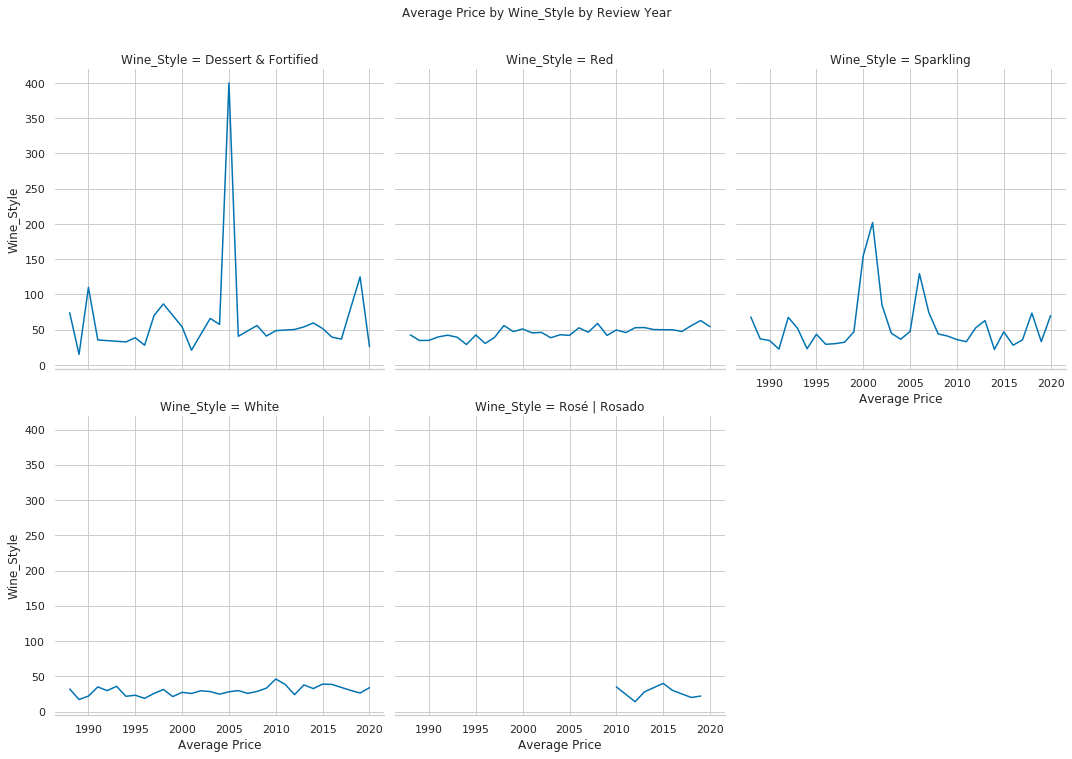

In [592]:
summary_by_year_lineplot('Price', 'Wine_Style')

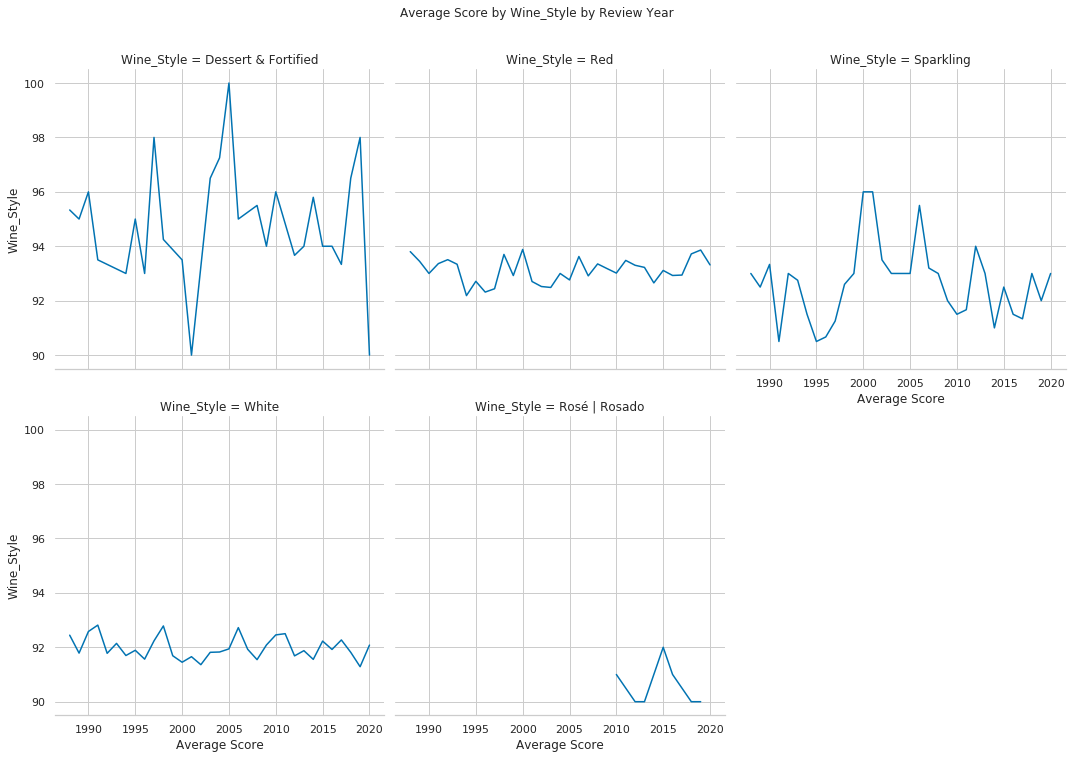

In [593]:
summary_by_year_lineplot('Score', 'Wine_Style')

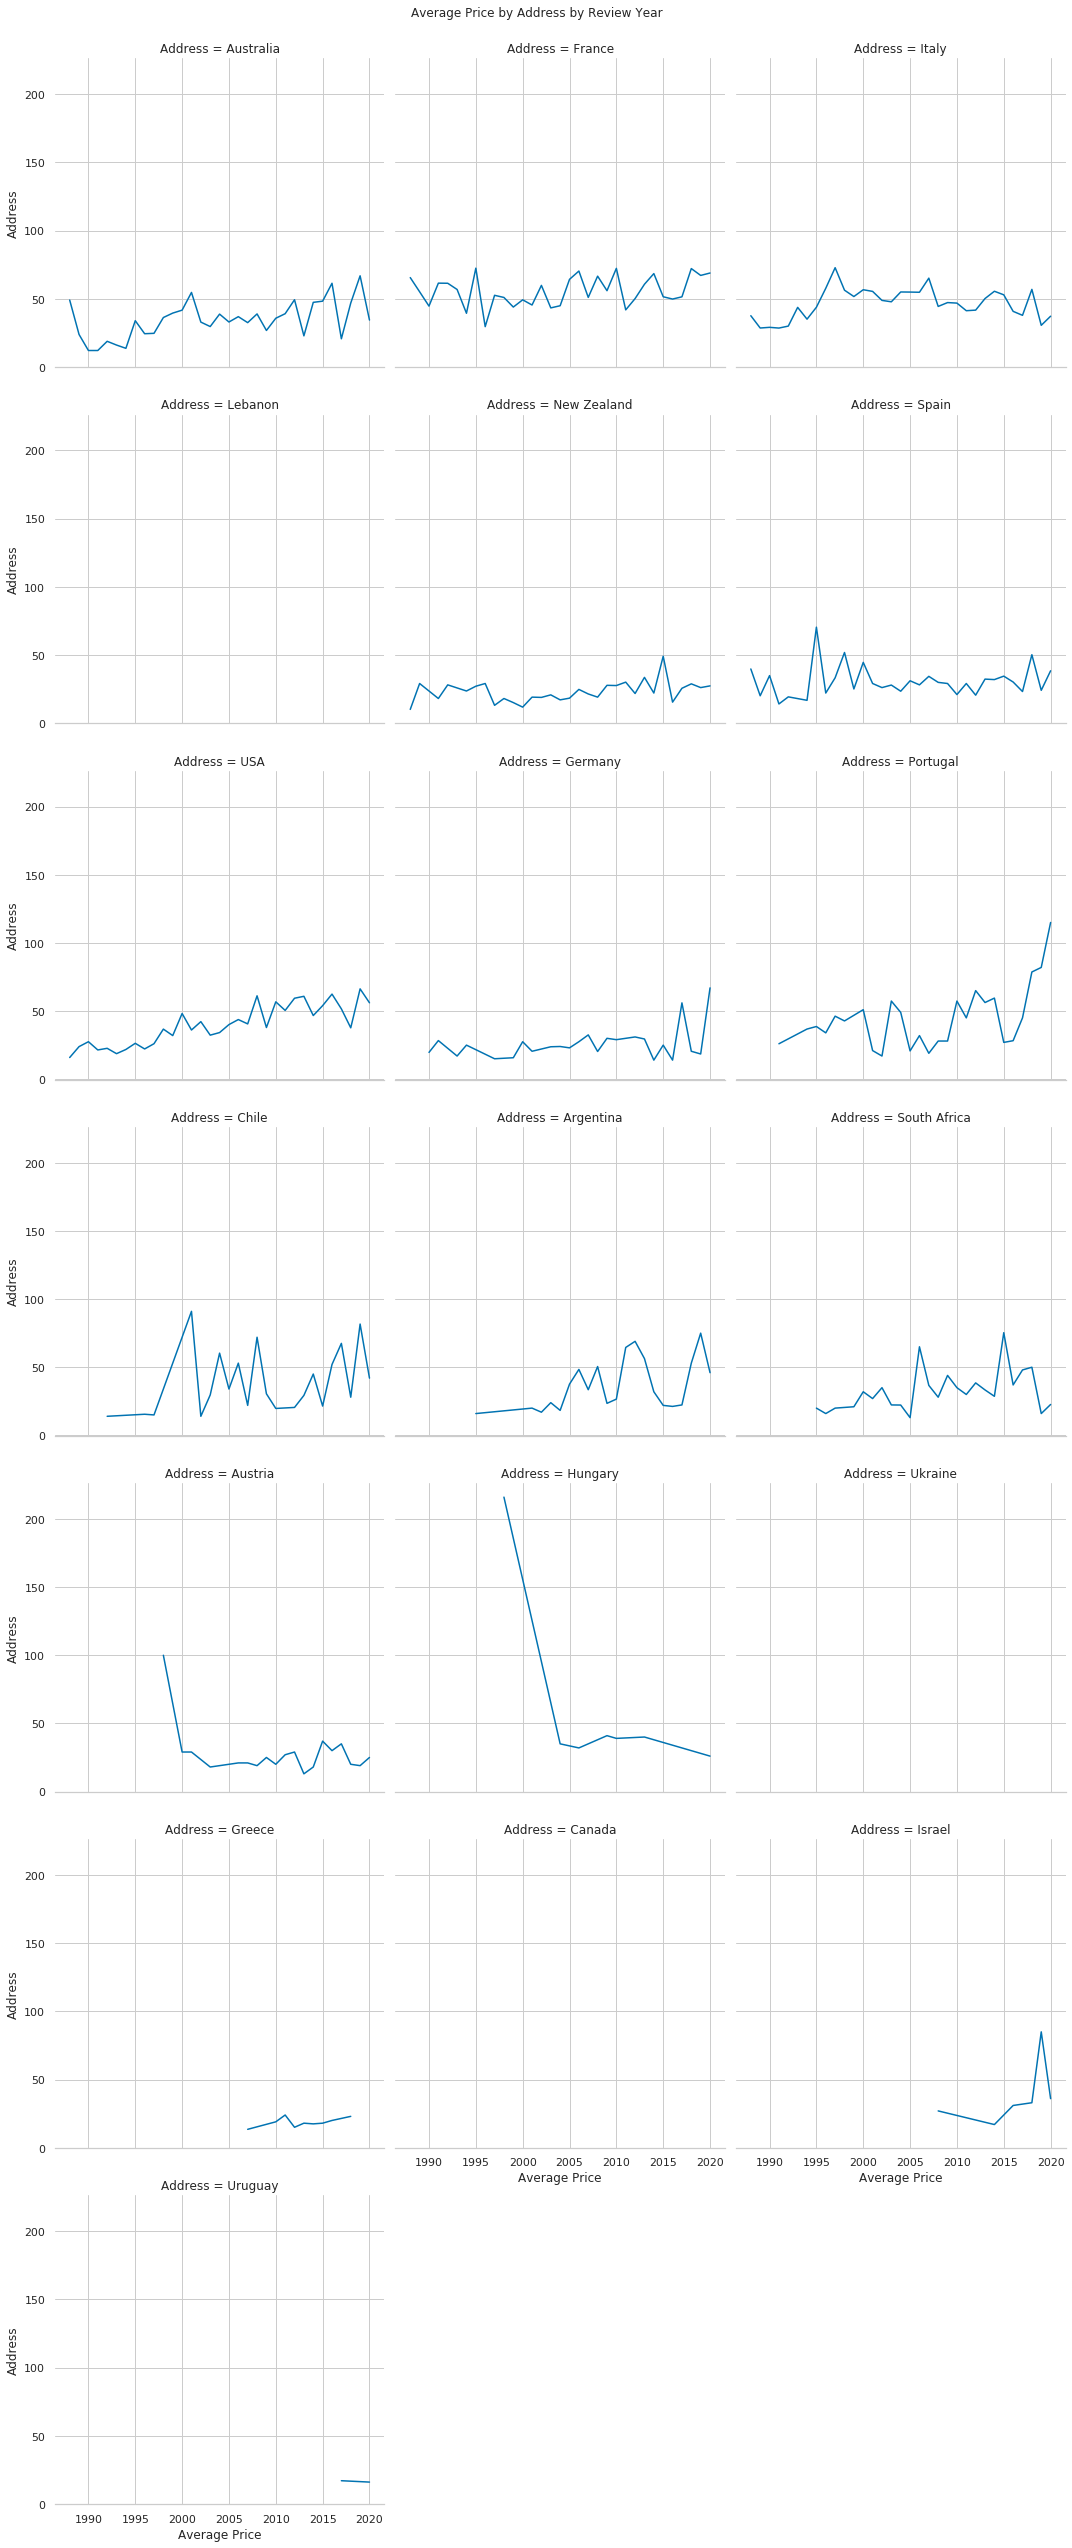

In [594]:
summary_by_year_lineplot('Price', 'Address')

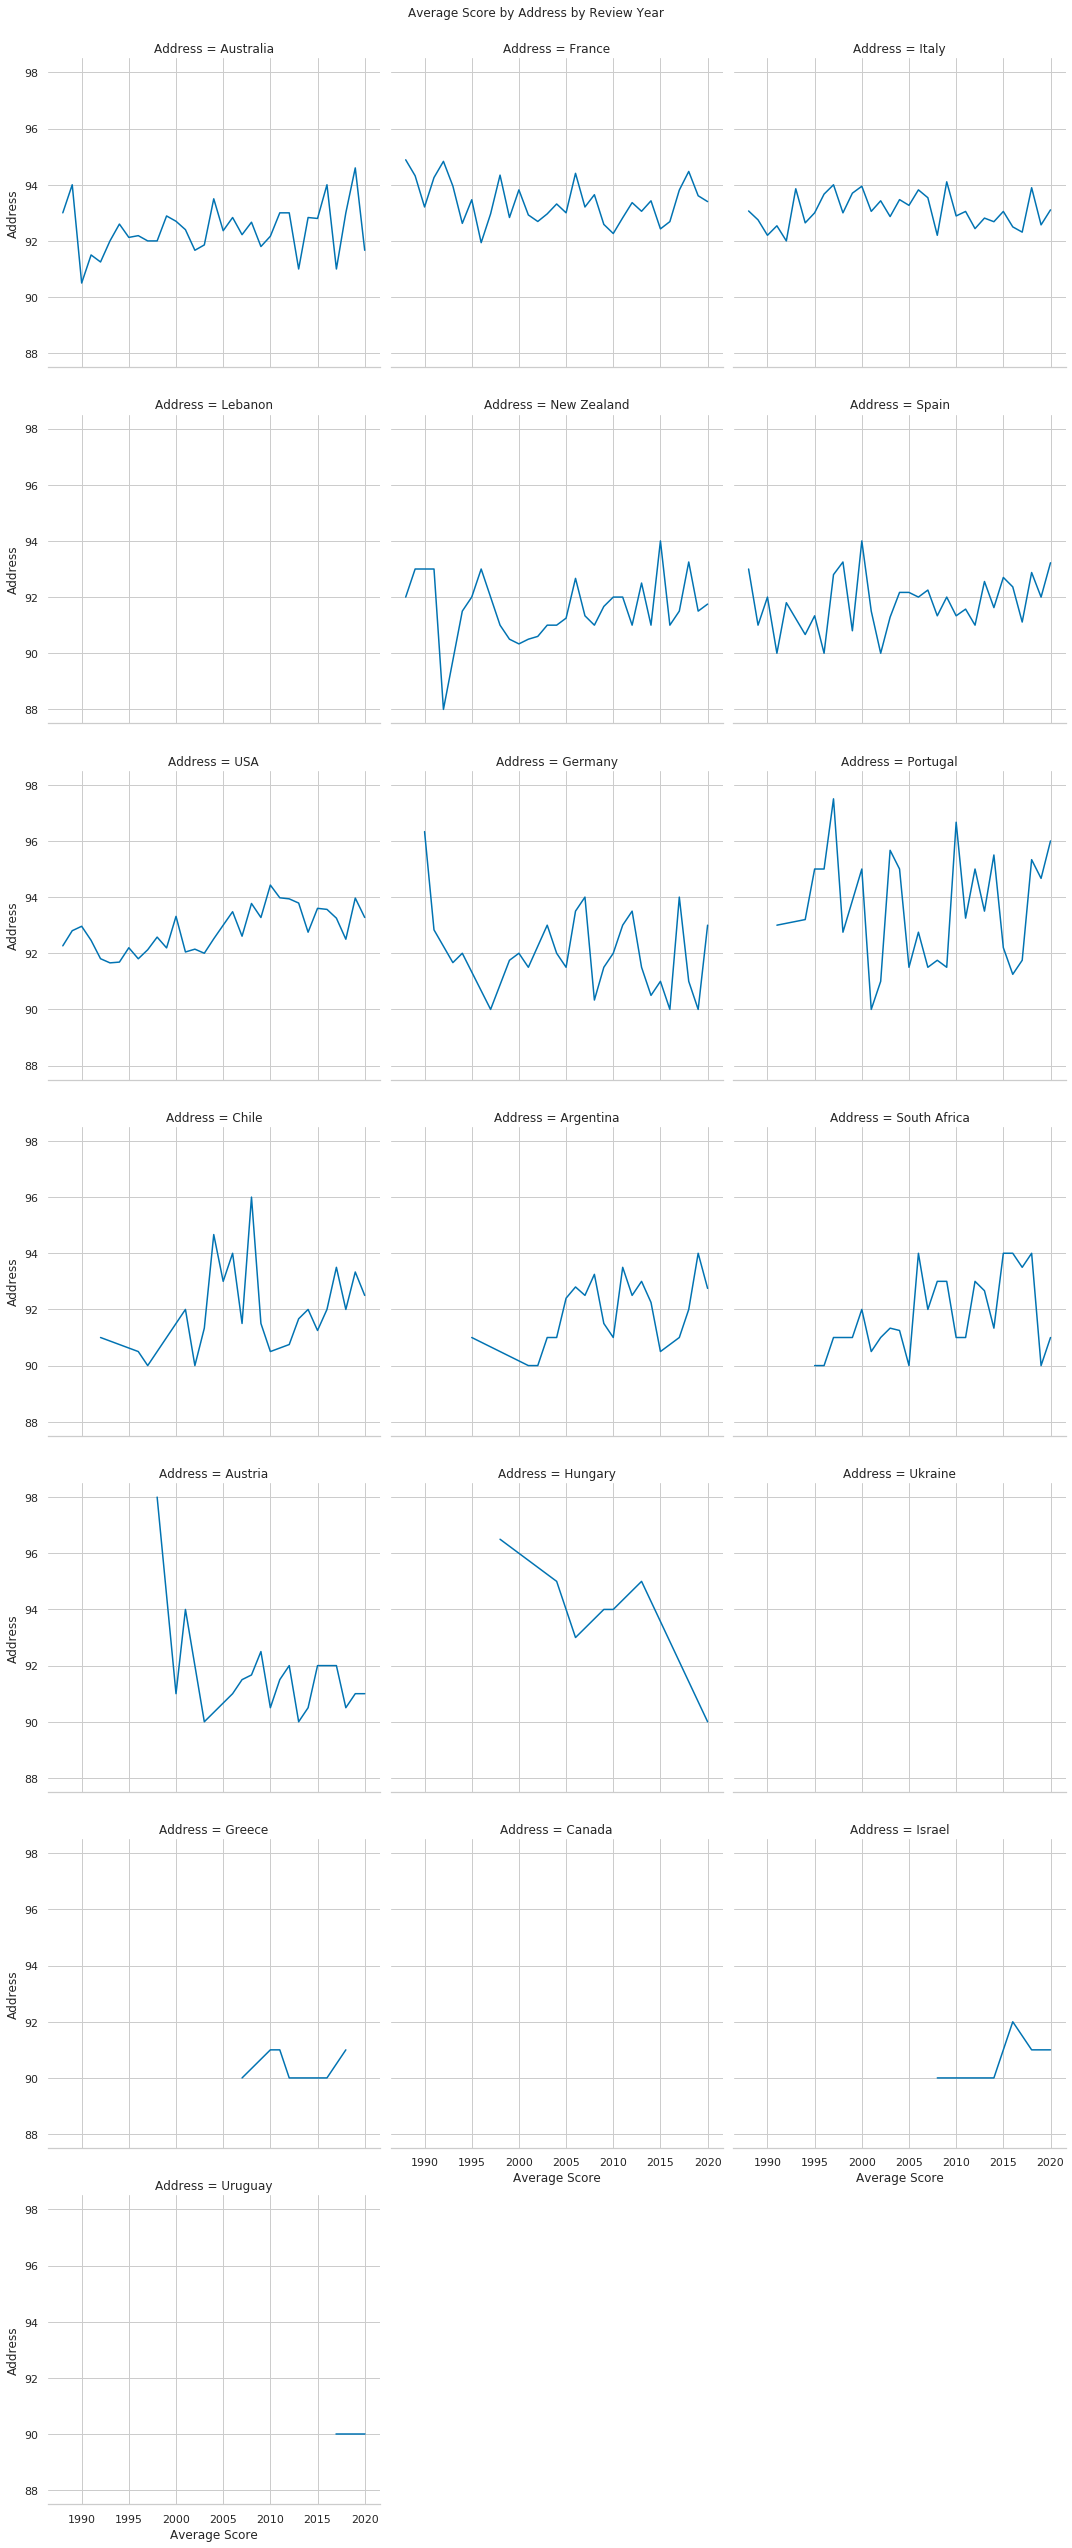

In [595]:
summary_by_year_lineplot('Score', 'Address')